# Ingredient‑Based Ground Truth Generation Notebook

**Abstract**

This notebook presents a **fully‑reproducible** pipeline for constructing *ingredient‑level ground‑truth* scenarios from a large recipe corpus.  
All processing steps are deterministic (fixed random seed) and ready for inclusion in an academic or industrial research manuscript.

**Key stages**

1. **Data ingestion & cleansing** – load the raw CSV, normalise ingredient lists.  
2. **Descriptive statistics** – explore ingredient popularity with visuals.  
3. **Equal‑frequency binning** & **stratified sampling** – guarantee both common *and* rare ingredients are represented.  
4. **Scenario generation** – enumerate ingredient sets (sizes 1 – 4) and count matching recipes.  
5. **Ground‑truth export** – persist CSVs mapping each scenario to the recipes that satisfy it.  
6. **Retention statistics** – summarise scenario coverage and sampling performance with plots.  


## 1  Introduction & Objectives

Evaluating recommendation models demands a robust ground truth.  
Here we treat *ingredient combinations* (size 1–4) as test scenarios and locate every recipe that contains all ingredients in the set.

**Goals**

* Cover both high‑ and low‑frequency ingredients via stratified sampling.  
* Maintain scenario diversity through equal‑frequency binning on *match counts*.  
* Produce shareable CSV exports for downstream benchmarking pipelines.  


## 2  Setup & Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import logging
import random
from collections import Counter
from itertools import combinations
from typing import List, Set, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ---------------------------- Configuration ----------------------------
INPUT_CSV       = "/content/drive/MyDrive/dataFullLargerRegionAndCountryWithServingsBin.csv"
OUTPUT_DIR      = "/content/ingredient_ground_truth"
RANDOM_SEED     = 42
SAMPLE_FRACTION = 0.25    # per‑bin sampling rate for sizes 3‑4
FULL_SIZES      = [1,2]  # retain all valid scenarios
SAMPLE_SIZES    = [3,4]  # apply sampling

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------- Logging & Style --------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    force=True,
)
log = logging.getLogger()

sns.set_theme(style="whitegrid")
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [ ]:
def get_bin_count(arr: np.ndarray,
                  method: str = 'fd',
                  min_bin_size_ratio: float = 0.05) -> int:
    """
    Calculate the number of bins for a histogram.
    Supports 'sturges', 'doane' and 'fd' (Freedman–Diaconis + min population).
    """
    n = len(arr)
    # 1) Sturges
    if method == 'sturges':
        return int(np.ceil(np.log2(n) + 1))
    # 2) Doane
    if method == 'doane':
        m2 = ((arr - arr.mean())**2).mean()
        m3 = ((arr - arr.mean())**3).mean()
        g1 = m3 / (m2**1.5) if m2 > 0 else 0
        sigma_g1 = np.sqrt(6*(n-2)/((n+1)*(n+3)))
        return int(np.ceil(1 + np.log2(n) + np.log2(1 + abs(g1)/sigma_g1)))
    # 3) Freedman–Diaconis
    data = pd.Series(arr).dropna()
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    fd_width = 2 * iqr * n**(-1/3)
    if fd_width <= 0:
        return max(1, int(np.sqrt(n)))
    initial_bins = int(np.ceil((data.max() - data.min()) / fd_width))
    min_samples = max(1, int(n * min_bin_size_ratio))
    for bins in range(initial_bins, 0, -1):
        try:
            b = pd.qcut(data, q=bins, duplicates='drop')
            if b.value_counts().min() >= min_samples:
                return bins
        except ValueError:
            continue
    return 1

## 3  Data Loading & Pre‑processing

In [ ]:
# 3.1  Load raw data
df = pd.read_csv(INPUT_CSV)
log.info(f"Loaded {len(df):,} recipes with columns: {list(df.columns)}")

# 3.2  Normalise ingredient lists
def split_ingredients(cell: str) -> List[str]:
    """Split semicolon‑delimited ingredients & strip whitespace. Return [] for NaNs."""
    if pd.isna(cell):
        return []
    return [item.strip() for item in str(cell).split(';') if item.strip()]

df['ingredient_list'] = df['BestUsdaIngredientName'].apply(split_ingredients)

2025-05-06 06:56:20 INFO: Loaded 88,519 recipes with columns: ['RecipeId', 'Name', 'Description', 'Images', 'RecipeCategory', 'Keywords', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeInstructions', 'cook_time', 'Healthy_Type', 'RecipeIngredientQuantities', 'RegionCountry', 'URL', 'occasion', 'meal_type', 'Diet_Types', 'ScrapedIngredients', 'RecipeIngredientParts', 'CleanedRegionCountry', 'CleanedRegion', 'Best_foodentityname', 'Best_foodentitylink', 'RegionPart', 'CountryPart', 'CuisineRegion', 'BestUsdaIngredientName', 'UsdaIngredientMappedId', 'Cooking_Method', 'servings_bin']


## 4  Ingredient Frequency Analysis

In [ ]:
# 4.1  Flatten ingredient occurrences
all_ings = [ing for lst in df['ingredient_list'] for ing in lst]

# 4.2  Frequency table
ing_counter = Counter(all_ings)
df_ing = (
    pd.DataFrame(ing_counter.items(), columns=['ingredient', 'count'])
      .sort_values('count', ascending=False)
      .reset_index(drop=True)
)
log.info(f"Identified {len(df_ing):,} unique ingredients.")

2025-05-06 06:56:20 INFO: Identified 1,646 unique ingredients.


<ipython-input-6-90bf919da368>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ing.head(20), x='count', y='ingredient', palette='mako')


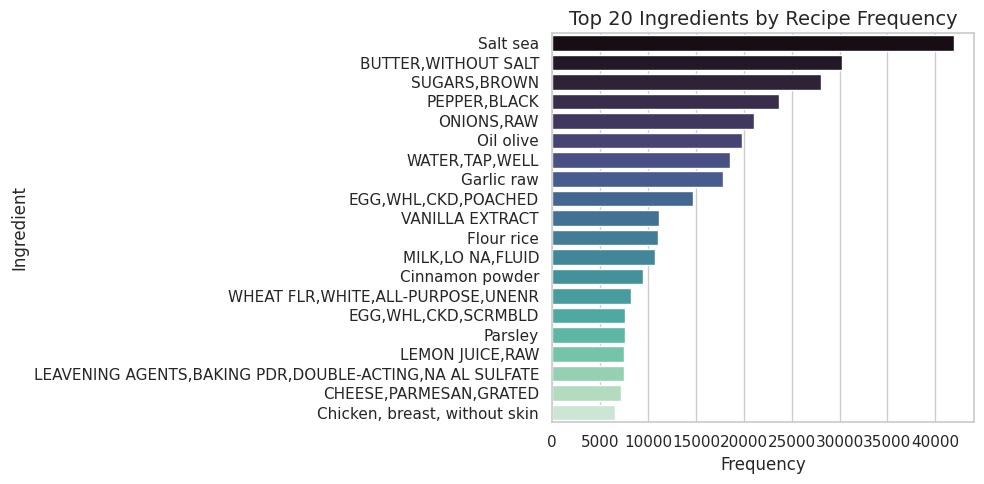

In [ ]:
# 4.3  Top‑20 ingredients bar chart
plt.figure(figsize=(10, 5))
sns.barplot(data=df_ing.head(20), x='count', y='ingredient', palette='mako')
plt.title("Top 20 Ingredients by Recipe Frequency", fontsize=14)
plt.xlabel("Frequency"); plt.ylabel("Ingredient")
plt.tight_layout(); plt.show()

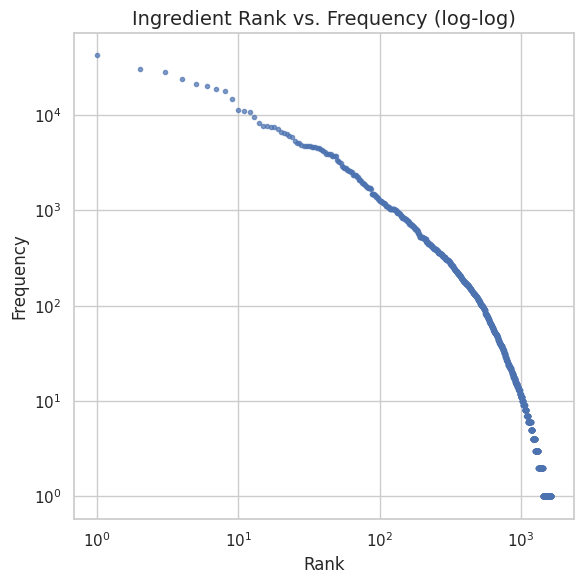

In [ ]:
# 4.4  Rank‑frequency (Zipf) plot
plt.figure(figsize=(6, 6))
plt.loglog(np.arange(1, len(df_ing)+1), df_ing['count'], '.', alpha=0.7)
plt.title("Ingredient Rank vs. Frequency (log‑log)", fontsize=14)
plt.xlabel("Rank"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

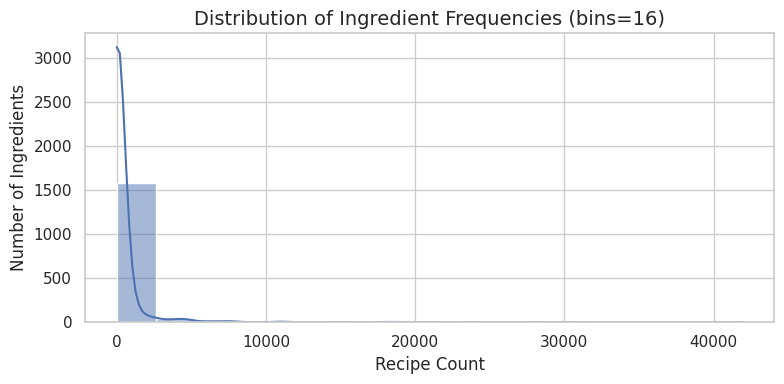

In [ ]:
num_bins = get_bin_count(df_ing['count'].values)                # <<< DİNAMİK BİN
plt.figure(figsize=(8, 4))
sns.histplot(df_ing['count'], bins=num_bins, kde=True)          # <<< DİNAMİK BİN
plt.title(f"Distribution of Ingredient Frequencies (bins={num_bins})", fontsize=14)
plt.xlabel("Recipe Count"); plt.ylabel("Number of Ingredients")
plt.tight_layout(); plt.show()

## 5  Ingredient Binning & Stratified Sampling

2025-05-06 06:56:46 INFO: Bin edges: [1.00000e+00 2.00000e+00 4.00000e+00 6.00000e+00 1.00000e+01 1.50000e+01
 2.40000e+01 3.90000e+01 6.22500e+01 1.06000e+02 1.69000e+02 2.94120e+02
 5.08750e+02 1.21944e+03 4.19480e+04] (q=16)
2025-05-06 06:56:46 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
<ipython-input-9-e18c4c19f4c9>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_counts.index, y=bin_counts.values, palette='rocket')
2025-05-06 06:56:46 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


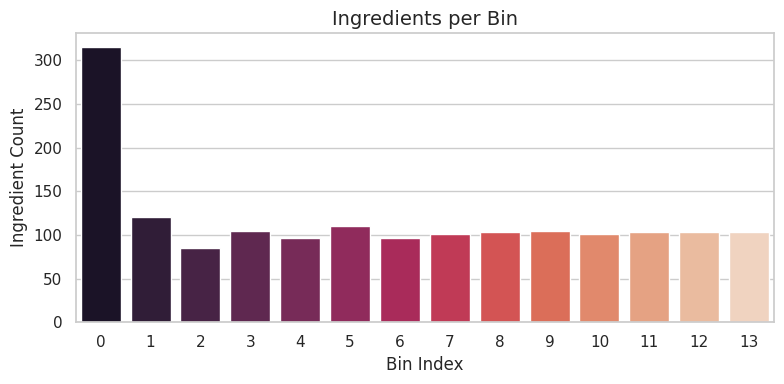

In [ ]:
# 5.1  Equal-frequency (quantile) binning (dinamik q)
q = min(num_bins, len(df_ing))                                 # <<< DİNAMİK BİN
df_ing['bin'], bin_edges = pd.qcut(
    df_ing['count'],
    q=q,
    labels=False,
    retbins=True,
    duplicates='drop'
)
log.info(f"Bin edges: {np.round(bin_edges, 2)} (q={q})")

# 5.2  Visualise ingredient count per bin
plt.figure(figsize=(8, 4))
bin_counts = df_ing['bin'].value_counts().sort_index()
sns.barplot(x=bin_counts.index, y=bin_counts.values, palette='rocket')
plt.title("Ingredients per Bin", fontsize=14)
plt.xlabel("Bin Index"); plt.ylabel("Ingredient Count")
plt.tight_layout(); plt.show()

In [ ]:
  # 5.3  10 % stratified sampling from each bin
  sampled_ing = (
      df_ing.groupby('bin', group_keys=False)
            .apply(lambda g: g.sample(frac=SAMPLE_FRACTION, random_state=RANDOM_SEED))
            .reset_index(drop=True)
  )
  log.info(f"Sampled {len(sampled_ing):,} ingredients (~{int(SAMPLE_FRACTION*100)} % per bin)")
  selected_ingredients = sampled_ing['ingredient'].tolist()

<ipython-input-10-3ba6b65e21f9>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=SAMPLE_FRACTION, random_state=RANDOM_SEED))
2025-05-06 06:56:46 INFO: Sampled 412 ingredients (~25 % per bin)


## 6  Scenario Generation & Retention

In [ ]:
# 6.1  Build inverted index: ingredient -> set(recipe_index)
ingredient_index: Dict[str, Set[int]] = {
    ingr: set(df.index[df['ingredient_list'].apply(lambda lst, x=ingr: x in lst)])
    for ingr in selected_ingredients
}

def count_matches(combo: Tuple[str, ...]) -> int:
    """Number of recipes that contain *all* ingredients in `combo`."""
    sets = [ingredient_index[i] for i in combo]
    return len(set.intersection(*sets))

# 6.2  Enumerate combos size 1–4 (streaming to disk)
import csv
import math

for size in range(1, 5):
    total = math.comb(len(selected_ingredients), size)
    out_path = os.path.join(OUTPUT_DIR, f"ground_truth_size_{size}.csv")

    with open(out_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        # write header
        writer.writerow([
            'scenario_size', 'combo', 'match_count',
            'recipe_ids', 'recipe_names'
        ])

        buffer = []
        for combo in tqdm(combinations(selected_ingredients, size),
                          total=total, desc=f"Size {size}"):
            cnt = count_matches(combo)
            if cnt == 0:
                continue

            # find matching recipe IDs and names
            idxs      = set.intersection(*(ingredient_index[i] for i in combo))
            rec_ids   = (df.loc[list(idxs), 'RecipeId']
                         if 'RecipeId' in df.columns else list(idxs))
            rec_names = (df.loc[list(idxs), 'Name']
                         if 'Name'     in df.columns else ['Unknown'] * len(idxs))

            buffer.append([
                size,
                ';'.join(combo),
                cnt,
                ','.join(map(str, rec_ids)),
                ' ||| '.join(map(str, rec_names))
            ])

            # flush buffer to disk every 10k records
            if len(buffer) >= 10000:
                writer.writerows(buffer)
                buffer.clear()

        # write any remaining rows
        if buffer:
            writer.writerows(buffer)

    log.info(f"Finished enumeration for size {size} → {out_path}")


Size 1: 100%|██████████| 412/412 [00:00<00:00, 893.86it/s] 
2025-05-06 06:57:01 INFO: Finished enumeration for size 1 → /content/ingredient_ground_truth/ground_truth_size_1.csv
Size 2: 100%|██████████| 84666/84666 [00:06<00:00, 12666.46it/s]
2025-05-06 06:57:08 INFO: Finished enumeration for size 2 → /content/ingredient_ground_truth/ground_truth_size_2.csv
Size 3: 100%|██████████| 11571020/11571020 [00:42<00:00, 273045.85it/s]
2025-05-06 06:57:51 INFO: Finished enumeration for size 3 → /content/ingredient_ground_truth/ground_truth_size_3.csv
Size 4: 100%|██████████| 1183136795/1183136795 [26:00<00:00, 757983.33it/s]
2025-05-06 07:23:52 INFO: Finished enumeration for size 4 → /content/ingredient_ground_truth/ground_truth_size_4.csv


## 7  Ground‑Truth Export

In [ ]:
import math
import pandas as pd

stats = []
for size in range(1,5):
    total    = math.comb(len(selected_ingredients), size)
    path     = os.path.join(OUTPUT_DIR, f"ground_truth_size_{size}.csv")
    retained = sum(1 for _ in open(path)) - 1  # header’ı çıkar
    stats.append({'size': size, 'total': total, 'retained': retained})

stats_df = pd.DataFrame(stats)
display(stats_df)


,size,total,retained
0,1,412,412
1,2,84666,9096
2,3,11571020,33133
3,4,1183136795,47692


## 8  Summary Statistics & Visualisation

,size,total,retained
0,1,412,412
1,2,84666,9096
2,3,11571020,33133
3,4,1183136795,47692


2025-05-06 07:23:53 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-06 07:23:53 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


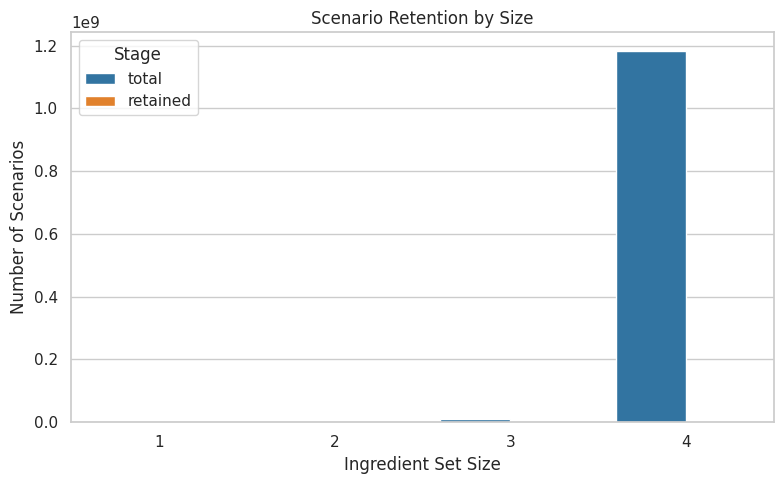

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 7. Son İstatistikler & Retention Grafiği
stats = []
for size in range(1, 5):
    # Tüm kombinasyon sayısı
    total = math.comb(len(selected_ingredients), size)
    # Streaming ile yazdığımız dosya yolu
    path = os.path.join(OUTPUT_DIR, f"ground_truth_size_{size}.csv")
    # Header satırını çıkararak kalan satır sayısını al
    with open(path, 'r', encoding='utf-8') as f:
        retained = sum(1 for _ in f) - 1

    stats.append({
        'size': size,
        'total': total,
        'retained': retained
    })

stats_df = pd.DataFrame(stats)
display(stats_df)

# Retention grafiği
plot_df = stats_df.melt(
    id_vars='size',
    value_vars=['total', 'retained'],
    var_name='stage',
    value_name='count'
)

plt.figure(figsize=(8, 5))
sns.barplot(data=plot_df, x='size', y='count', hue='stage', palette='tab10')
plt.title("Scenario Retention by Size")
plt.xlabel("Ingredient Set Size")
plt.ylabel("Number of Scenarios")
plt.legend(title="Stage")
plt.tight_layout()
plt.show()


<a id='Repro'></a>
## 9  Reproducibility Checklist

| Item | Value |
|------|-------|
| **Notebook generated** | 2025‑04‑20 20:29 UTC |
| **Random seed** | 42 |
| **CSV source** | `dataFullLargerRegionAndCountryWithServingsBin.csv` |
| **Output directory** | `/content/ingredient_ground_truth` |

–– End of notebook ––


In [ ]:
import pandas as pd
df = pd.read_csv('/content/ingredient_ground_truth/ground_truth_size_3.csv')
df.head()

,scenario_size,combo,match_count,recipe_ids,recipe_names
0,3,"WATER,W/ CORN SYRUP AND/OR SUGAR & LO CAL SWTN...",1,479778,Korean Red Pepper Paste Chicken
1,3,"WATER,W/ CORN SYRUP AND/OR SUGAR & LO CAL SWTN...",1,479778,Korean Red Pepper Paste Chicken
2,3,"WATER,W/ CORN SYRUP AND/OR SUGAR & LO CAL SWTN...",1,479778,Korean Red Pepper Paste Chicken
3,3,"WATER,W/ CORN SYRUP AND/OR SUGAR & LO CAL SWTN...",1,479778,Korean Red Pepper Paste Chicken
4,3,"WATER,W/ CORN SYRUP AND/OR SUGAR & LO CAL SWTN...",1,479778,Korean Red Pepper Paste Chicken


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33133 entries, 0 to 33132
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   scenario_size  33133 non-null  int64 
 1   combo          33133 non-null  object
 2   match_count    33133 non-null  int64 
 3   recipe_ids     33133 non-null  object
 4   recipe_names   33133 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.3+ MB
